In [1]:
#Verify we are in the lesson1 directory
%pwd

'/home/swaroop/Downloads/deeplearning_nbs'

In [2]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = '/home/swaroop/Downloads/deeplearning_nbs'
DATA_HOME_DIR = '/home/swaroop/Downloads/deeplearning_nbs'+'/data/wyeths-dogscats-inside'

In [3]:
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

#import modules
from utils import *
from vgg16 import Vgg16

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

Using TensorFlow backend.


## Action Plan
1. Create Validation and Sample sets
2. Rearrange image files into their respective directories 
3. Finetune and Train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to Kaggle

## Finetuning and Training

In [4]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR  #'/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

/home/swaroop/Downloads/deeplearning_nbs/data/wyeths-dogscats-inside


In [5]:
from keras import backend as K
K.set_image_dim_ordering('th')

from keras.models import Sequential
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D

img_width, img_height = 128, 128

In [6]:
#import Vgg16 helper class
vgg = Vgg16()

In [7]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=4
no_of_epochs=2

In [8]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.01

Found 42 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [9]:
import random 
random.seed(123)

In [10]:
# swaroop code based on lecture 

#vgg.fit(batches, val_batches, nb_epoch=1)

latest_weights_filename = None
no_of_epochs=2

for batch_size in [8]:
    for epoch in range(no_of_epochs):
        print ("Running epoch: %d" % epoch)
        print ("Running batch_size: %d" % batch_size)
        vgg.fit(batches, val_batches, nb_epoch=1)
        latest_weights_filename = 'ft%d.h5' % epoch
        #vgg.model.save_weights(results_path+latest_weights_filename)
    print ("Completed %s fit operations" % no_of_epochs)

Running epoch: 0
Running batch_size: 8
Epoch 1/1
42/42 [==============================] - 164s - loss: 3.5203 - acc: 0.5952 - val_loss: 7.2270 - val_acc: 0.5000
Running epoch: 1
Running batch_size: 8
Epoch 1/1
42/42 [==============================] - 157s - loss: 3.7689 - acc: 0.6667 - val_loss: 5.1781 - val_acc: 0.6250
Completed 2 fit operations


## Generate Predictions

Let's use our new model to make predictions on the test dataset

In [11]:
batches, preds = vgg.test(test_path, batch_size = batch_size*2)

Found 10 images belonging to 2 classes.


In [16]:
filenames = batches.filenames
expected_labels = batches.classes #0 or 1

print (expected_labels)
#Round our predictions to 0/1 to generate labels
our_predictions = preds[:,0]
#print (our_predictions)
our_labels = np.round(1-our_predictions)
print (our_labels)

from sklearn.metrics import roc_auc_score  


print ('ROC - ',roc_auc_score(expected_labels, preds[:,1]))


[0 0 0 0 0 1 1 1 1 1]
[ 0.  0.  1.  0.  0.  0.  1.  1.  0.  0.]
ROC -  0.56


In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

[[4 1]
 [3 2]]


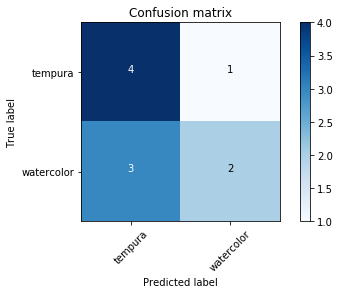

In [14]:
plot_confusion_matrix(cm, val_batches.class_indices)

## Validate Predictions

Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to reduce over-fitting - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Let's see what we can learn from these examples. (In general, this is a particularly useful technique for debugging problems in the model. However, since this model is so simple, there may not be too much to learn at this stage.)

Calculate predictions on validation set, so we can find correct and incorrect examples: